In [263]:
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Dropout, BatchNormalization, MaxPooling1D, UpSampling1D, Reshape, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling, random_normal, TruncatedNormal, lecun_normal
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [307]:
def autoencoder(dims, act="relu", init="glorot_uniform", dropout=False):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1

    input_data = Input(shape=(dims[0],), name="input")
    x = input_data

    # internal layers of encoder
    for i in range(n_stacks - 1):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x = Dense(
            dims[i + 1], activation=act, kernel_initializer=init, name="encoder_%d" % i
        )(x)
        x=BatchNormalization()(x)

    # latent hidden layer
    encoded = Dense(
        dims[-1], kernel_initializer=init, name="encoder_%d" % (n_stacks - 1)
    )(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks - 1, 0, -1):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x=BatchNormalization()(x)
        x = Dense(
            dims[i], activation=act, kernel_initializer=init, name="decoder_%d" % i
        )(x)

    # decoder output

    x = Dense(dims[0], kernel_initializer=init, name="decoder_0")(x)

    decoded = x

    autoencoder_model = Model(inputs=input_data, outputs=decoded, name="autoencoder")
    encoder_model = Model(inputs=input_data, outputs=encoded, name="encoder")

    return autoencoder_model, encoder_model

In [306]:
def autoencoder(dims, act="relu", init="glorot_uniform", dropout=False):
    """
    Fully connected symmetric auto-encoder model.
    Conv1D implementation.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims)

    input_data = Input(shape=(dims[0],), name="input")
    x = input_data
    
    x = Reshape((dims[0],1))(x)

    # internal layers of encoder
    for i in range(1, n_stacks):
        x = Conv1D(
            2*2**(i-1), dims[i], activation='relu',padding='same', kernel_initializer=init, name="encoder_%d" % i
        )(x)
        x=MaxPooling1D(4,padding='same')(x)

    # latent hidden layer
    x = Conv1D(
            2*2**(len(dims)-1), 1, activation='relu',padding='same' , kernel_initializer=init, name="encoder_%d" % len(dims))(x)
    encoded = x

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks - 1, 0, -1):
        x=UpSampling1D(4)(x)
        x = Conv1D(
            2*2**(i-1), 1, activation='relu',padding='same', kernel_initializer=init, name="decoder_%d" % i
        )(x)

    # decoder output

    x = Conv1D(1, 1, activation=None, kernel_initializer=init,padding='same', name="decoder0_%d" % i)(x)

    decoded = Reshape((dims[0],))(x)

    autoencoder_model = Model(inputs=input_data, outputs=decoded, name="autoencoder")
    encoder_model = Model(inputs=input_data, outputs=encoded, name="encoder")

    return autoencoder_model, encoder_model
dims=[input_X.shape[-1],20,10]
autoencoder1, encoder1 = autoencoder(dims, init=init, dropout=True)
autoencoder1.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
reshape_115 (Reshape)        (None, 400, 1)            0         
_________________________________________________________________
encoder_1 (Conv1D)           (None, 400, 2)            42        
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, 100, 2)            0         
_________________________________________________________________
encoder_2 (Conv1D)           (None, 100, 4)            84        
_________________________________________________________________
max_pooling1d_137 (MaxPoolin (None, 25, 4)             0         
_________________________________________________________________
encoder_3 (Conv1D)           (None, 25, 8)             

## Tuning layer dim hyperparameters so that the performance of SAE is guarenteed

In [4]:
all_data=pd.read_csv('data/DEC_input_data.csv',index_col=0)
all_data.head()

,company,0,1,2,3,4,5,6,7,8,...,390,391,392,393,394,395,396,397,398,399
0,603363.SH,0.063819,-0.092597,0.002911,0.055891,0.054983,-0.043466,-0.140912,-0.141828,0.031578,...,-0.159557,0.036761,0.026463,-0.064431,0.049545,0.010073,-0.062302,0.011767,0.010054,-0.238330
1,603128.SH,-0.044297,-0.220316,0.167500,-0.031909,0.190416,0.041890,-0.184343,-0.113558,0.016526,...,-0.220619,0.123803,0.213640,-0.058178,0.042985,0.046311,-0.008052,-0.107274,-0.073975,-0.108647
2,688039.SH,0.063011,-0.102117,0.094187,-0.058387,0.145465,-0.018332,-0.080607,-0.183837,0.072533,...,-0.149341,0.002006,0.154207,-0.004786,0.014591,-0.091468,-0.020249,-0.101905,0.033099,-0.163123
3,603127.SH,0.007177,-0.073692,0.032569,0.025217,0.058173,-0.020243,-0.078097,-0.126371,0.037486,...,-0.138615,0.037804,0.012622,-0.021271,0.079883,-0.025067,-0.043388,0.048489,0.033115,-0.069359
4,601068.SH,-0.060659,-0.041156,0.126778,-0.058494,0.116213,0.043243,-0.148467,-0.153482,0.034922,...,-0.065672,0.119754,0.082636,-0.017870,0.045117,0.052986,-0.057587,-0.110045,0.000645,-0.065503


In [308]:
input_X = all_data.iloc[:, 1:]
companylist = all_data['company'].values.tolist()
# input_X=bag_matrix.iloc[:,1:]
n_epochs = 200
batch_size = 128
CNNdims=[input_X.shape[-1],20,10]
dims = [input_X.shape[-1], 500, 200, 2000, 50]
#init = VarianceScaling(scale=1.0 / 3.0, mode="fan_in", distribution="uniform")
init = lecun_normal()
pretrain_optimizer = SGD(lr=0.01, momentum=0.9,decay=0.01/n_epochs)
pretrain_epochs = n_epochs
batch_size = batch_size

In [309]:
autoencoder, encoder = autoencoder(dims, init=init, dropout=0.2)
autoencoder.compile(optimizer=pretrain_optimizer, loss="mse")
autoencoder.fit(input_X, input_X, batch_size=batch_size, epochs=pretrain_epochs)

Epoch 1/200
3924/3924 [==============================] - 1s 303us/step - loss: 0.4104
Epoch 2/200
3924/3924 [==============================] - 1s 149us/step - loss: 0.2817
Epoch 3/200
3924/3924 [==============================] - 1s 150us/step - loss: 0.2398
Epoch 4/200
3924/3924 [==============================] - 1s 150us/step - loss: 0.2067
Epoch 5/200
3924/3924 [==============================] - 1s 149us/step - loss: 0.1770
Epoch 6/200
3924/3924 [==============================] - 1s 149us/step - loss: 0.1530
Epoch 7/200
3924/3924 [==============================] - 1s 150us/step - loss: 0.1338
Epoch 8/200
3924/3924 [==============================] - 1s 149us/step - loss: 0.1191
Epoch 9/200
3924/3924 [==============================] - 1s 149us/step - loss: 0.1073
Epoch 10/200
3924/3924 [==============================] - 1s 148us/step - loss: 0.0964
Epoch 11/200
3924/3924 [==============================] - 1s 148us/step - loss: 0.0879
Epoch 12/200
3924/3924 [============================

In [310]:
# BERT matrix
Y_pred = autoencoder.predict(input_X)
triu_elements_pred = [
    a for a in np.nditer(np.triu(cosine_similarity(input_X, Y_pred), 1)) if a > 0
]
triu_elements_ori = [
    a for a in np.nditer(np.triu(cosine_similarity(input_X), 1)) if a > 0
]
print(
    "Average similarity after SAE processing: "
    + str(round(np.mean(triu_elements_pred), 4))
)
print(
    "Std similarity after SAE processing: " + str(round(np.std(triu_elements_pred), 6))
)
print("Original average similarity: " + str(round(np.mean(triu_elements_ori), 4)))
print("Original std similarity: " + str(round(np.std(triu_elements_ori), 4)))

Average similarity after SAE processing: 0.7272
Std similarity after SAE processing: 0.108692
Original average similarity: 0.7044
Original std similarity: 0.1421


In [ ]:
# Bag of words matrix
Y_pred = autoencoder.predict(input_X)
triu_elements_pred = [
    a for a in np.nditer(np.triu(cosine_similarity(input_X, Y_pred), 1)) if a > 0
]
triu_elements_ori = [
    a for a in np.nditer(np.triu(cosine_similarity(input_X), 1)) if a > 0
]
print(
    "Average similarity after SAE processing: "
    + str(round(np.mean(triu_elements_pred), 4))
)
print(
    "Std similarity after SAE processing: " + str(round(np.std(triu_elements_pred), 6))
)
print("Original average similarity: " + str(round(np.mean(triu_elements_ori), 4)))
print("Original std similarity: " + str(round(np.std(triu_elements_ori), 4)))

In [311]:
# save the SAE weight
autoencoder.save_weights("DEC_model_output/bow_sae_model_weights.h5")

## Define the DAE clustering layer

In [251]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [252]:
loss = 0
index = 0
maxiter = 1000
n_clusters = 26
update_interval = 100
index_array = np.arange(input_X.shape[0])
tol = 0.001  # tolerance threshold to stop training

In [318]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if "input_shape" not in kwargs and "input_dim" in kwargs:
            kwargs["input_shape"] = (kwargs.pop("input_dim"),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(
            name="clusters",
            shape=(self.n_clusters, input_dim),
            initializer="glorot_uniform",
        )

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (
            1.0
            + (
                K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2)
                / self.alpha
            )
        )
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(
            K.transpose(q) / K.sum(q, axis=1)
        )  # Make sure all of the values of each sample sum up to 1.

        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {"n_clusters": self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# Need to re-run autoencoder function declaration!!!
def autoencoder(dims, act="relu", init="glorot_uniform", dropout=False):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1

    input_data = Input(shape=(dims[0],), name="input")
    x = input_data

    # internal layers of encoder
    for i in range(n_stacks - 1):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x = Dense(
            dims[i + 1], activation=act, kernel_initializer=init, name="encoder_%d" % i
        )(x)
        x=BatchNormalization()(x)

    # latent hidden layer
    encoded = Dense(
        dims[-1], kernel_initializer=init, name="encoder_%d" % (n_stacks - 1)
    )(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks - 1, 0, -1):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x=BatchNormalization()(x)
        x = Dense(
            dims[i], activation=act, kernel_initializer=init, name="decoder_%d" % i
        )(x)

    # decoder output

    x = Dense(dims[0], kernel_initializer=init, name="decoder_0")(x)

    decoded = x

    autoencoder_model = Model(inputs=input_data, outputs=decoded, name="autoencoder")
    encoder_model = Model(inputs=input_data, outputs=encoded, name="encoder")

    return autoencoder_model, encoder_model

In [319]:
autoencoder, encoder = autoencoder(dims, init=init, dropout=True)
autoencoder.load_weights("DEC_model_output/bow_sae_model_weights.h5")
clustering_layer = ClusteringLayer(n_clusters, name="clustering")(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

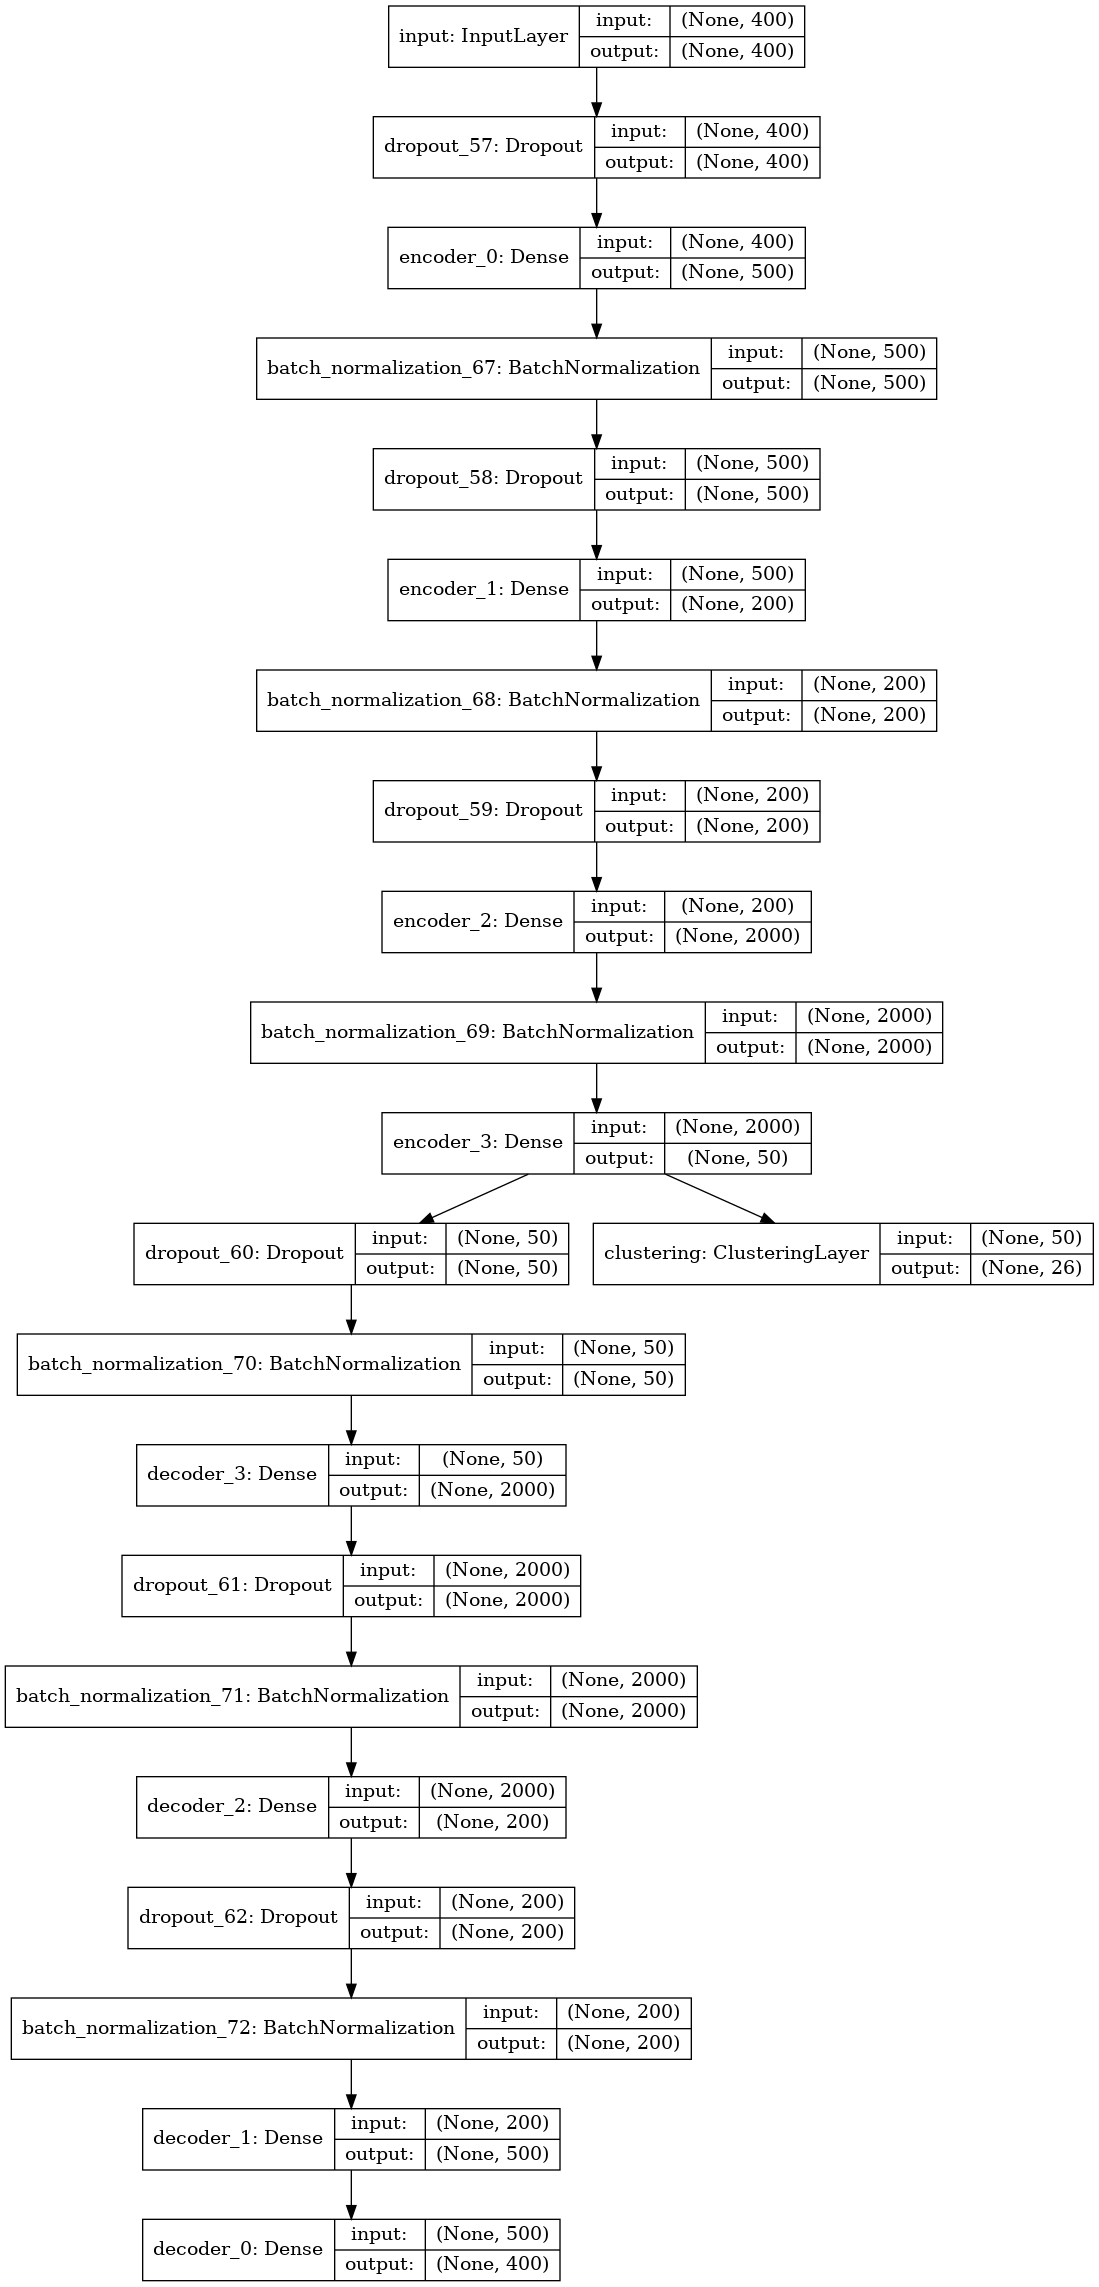

In [320]:
from keras.utils import plot_model

plot_model(model, to_file="DEC_model_output/encoder.png", show_shapes=True)
from IPython.display import Image

Image(filename="DEC_model_output/encoder.png")

### Initialize the clustering weights to kmeans results

In [342]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(input_X))
model.get_layer(name="clustering").set_weights([kmeans.cluster_centers_])
y_pred_kmean = np.copy(y_pred)

In [343]:
y_pred_last = np.copy(y_pred)

In [344]:
kmean_cluster_df = pd.DataFrame({"company": companylist, "kmean_cluster": y_pred_kmean})
kmean_cluster_df.groupby("kmean_cluster").count()

,company
kmean_cluster,
0,61
1,412
2,26
3,145
4,43
5,4
6,114
7,520
8,247


In [345]:
model.compile(loss=["kld", "mse"], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [346]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(input_X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print("delta_label ", delta_label, "< tol ", tol)
            print("Reached tolerance threshold. Stopping training.")
            break
    idx = index_array[
        index * batch_size : min((index + 1) * batch_size, input_X.shape[0])
    ]
    loss = model.train_on_batch(x=input_X.iloc[idx], y=[p[idx], input_X.iloc[idx]])
    index = index + 1 if (index + 1) * batch_size <= input_X.shape[0] else 0

In [347]:
# get the prediction
q, _ = model.predict(input_X, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

## Clustering result

In [348]:
# DEC cluster result
DEC_cluster_df = pd.DataFrame({"company": companylist, "DEC_cluster": y_pred})
DEC_cluster_df.groupby("DEC_cluster").count()

,company
DEC_cluster,
0,78
1,251
2,29
3,130
4,55
5,33
6,115
7,278
8,182


In [349]:
model.save_weights("DEC_model_output/bow_DEC_model_final.h5")
DEC_cluster_df.to_csv("data/bow_DEC_cluster.csv")

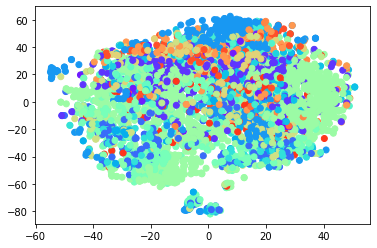

In [139]:
# DEC cluster
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(input_X)
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
colors = cm.rainbow((y_pred - np.min(y_pred)) / np.max(y_pred))
plt.scatter(vis_x, vis_y, c=colors)
plt.clim(-0.5, 9.5)
plt.show()

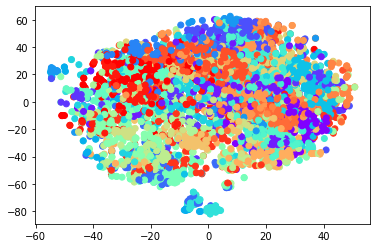

In [140]:
# k-mean cluster
colors = cm.rainbow((y_pred_kmean - np.min(y_pred_kmean)) / np.max(y_pred_kmean))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap("jet", 256))
plt.clim(-0.5, 9.5)
plt.show()